In [1]:
import pandas as pd
import os
import shutil
import yaml
from pathlib import Path
import ast
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
from typing import List, Tuple, Dict
from tqdm.notebook import tqdm

In [2]:
image_path = "/kaggle/input/vindr-mammogram-dataset-dicom-to-png/images_png/"
directory = Path(image_path)
file_paths = list(directory.glob("*"))
len(file_paths)

5000

In [3]:
data = pd.read_csv('/kaggle/input/vindr-findings/vindr_detection_v1_folds.csv')
data['finding_categories'] = data['finding_categories'].apply(ast.literal_eval)
data= data.drop(['height','width','xmin','ymin','xmax','ymax','fold',
           'Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry',
           'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding',
           'Skin_Retraction', 'Skin_Thickening', 'Suspicious_Calcification',
           'Suspicious_Lymph_Node', 'density'],axis=1)
data.head()

/tmp/ipykernel_30/1866978474.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/vindr-findings/vindr_detection_v1_folds.csv')


,patient_id,series_id,image_id,laterality,view,breast_birads,breast_density,finding_categories,finding_birads,split,resized_xmin,resized_ymin,resized_xmax,resized_ymax
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8.png,R,CC,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,485.695624,985.773942,609.595900,1078.419728
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,532.399692,743.812744,639.422675,812.095390
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1.png,R,CC,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,368.152714,499.060222,816.519337,1287.129503
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd.png,R,MLO,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,162.492921,726.730749,729.029452,1105.680056
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37.png,R,CC,BI-RADS 4,DENSITY C,[Architectural Distortion],BI-RADS 4,training,403.582493,1078.254802,580.267104,1203.183844


In [4]:
def display_images(data, idx):
    # Find the unique patient ID
    unique_patient_id = data['patient_id'][idx]
    
    # Filter data for this patient ID
    patient_data = data[data['patient_id'] == unique_patient_id]
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 5))
    axes = axes.ravel()

    for i, row in enumerate(patient_data.itertuples()):
        # Build image path
        img_file_path = os.path.join(image_path, row.patient_id, f"{row.image_id}")

        # Open and show image
        if os.path.exists(img_file_path):
            img = Image.open(img_file_path)
            try:
                axes[i].imshow(img, cmap='gray')
                
                # Draw bounding box
                rect = patches.Rectangle((row.resized_xmin, row.resized_ymin),
                                         row.resized_xmax - row.resized_xmin,
                                         row.resized_ymax - row.resized_ymin,
                                         linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
            except Exception as e:
                print(f"Cannot Display {img_file_path}, because of error:{e}")
                break
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set title with image attributes
        title_text = f"{i} Laterality: {row.laterality}, View: {row.view}, BIRADS: {row.breast_birads}, " \
                     f"Density: {row.breast_density}, Findings: {','.join(row.finding_categories)}"
        axes[i].set_title(title_text, fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [5]:
dw = data[~data['resized_xmin'].isnull()].copy() #Data containing Bounding Boxes, which is our focus for Object Detection
dw

,patient_id,series_id,image_id,laterality,view,breast_birads,breast_density,finding_categories,finding_birads,split,resized_xmin,resized_ymin,resized_xmax,resized_ymax
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8.png,R,CC,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,485.695624,985.773942,609.595900,1078.419728
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,training,532.399692,743.812744,639.422675,812.095390
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1.png,R,CC,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,368.152714,499.060222,816.519337,1287.129503
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd.png,R,MLO,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,training,162.492921,726.730749,729.029452,1105.680056
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37.png,R,CC,BI-RADS 4,DENSITY C,[Architectural Distortion],BI-RADS 4,training,403.582493,1078.254802,580.267104,1203.183844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,test,279.176226,792.258613,407.932101,881.475757
2250,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,test,87.032847,1060.220658,365.645343,1251.059411
2251,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,test,307.509650,1182.121037,484.871511,1261.599939
2252,0bfd4fcebaba4e9c4086edd05044a75f,255af1dcf2e5342bcc6bae1fc1a918cd,997e15346547ff56b4209ac73e74556f.png,L,MLO,BI-RADS 4,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 4,training,71.254133,753.280013,737.398896,1184.495964


In [6]:
#There are rows with more than one category, but only one BBOX Co-ordinate
#How do we match what category belongs to the BBOX Co-ordinate

dw[dw['finding_categories'].apply(len)>=2].head(10)

,patient_id,series_id,image_id,laterality,view,breast_birads,breast_density,finding_categories,finding_birads,split,resized_xmin,resized_ymin,resized_xmax,resized_ymax
8,7c51789da6c462e55bcb95c2a7d437ee,ac4d0771f6d7a7400ab463458f789dbe,f581ef53bb7e61f4575db33eceac8ff8.png,L,CC,BI-RADS 4,DENSITY C,"[Nipple Retraction, Mass]",BI-RADS 4,training,607.868846,700.577727,840.541260,951.560194
9,7c51789da6c462e55bcb95c2a7d437ee,ac4d0771f6d7a7400ab463458f789dbe,1142cdfbfe725d62038252693cf064e5.png,L,MLO,BI-RADS 4,DENSITY C,"[Nipple Retraction, Mass]",BI-RADS 4,training,609.653523,895.515554,899.498433,1136.661553
21,e233b75f7dc52e0ea37c88ad1c4df17d,1a1f62519a7fb1fd022e0bdae77786b7,8c799782afb5ab3a1a9cd5236dbddb98.png,L,CC,BI-RADS 4,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 4,training,57.717727,485.310409,223.034572,675.276620
22,e233b75f7dc52e0ea37c88ad1c4df17d,1a1f62519a7fb1fd022e0bdae77786b7,a869427ece4cb34d43825be65705929b.png,L,MLO,BI-RADS 4,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 4,training,409.876373,565.055277,646.440383,702.091296
37,b57b97020df361371ae1877080433275,9faef5a6512d0c95927d9140c6be0d02,5fe8350c930a08ebc532cbb304f5642a.png,L,CC,BI-RADS 5,DENSITY C,"[Suspicious Calcification, Architectural Disto...",BI-RADS 4,test,298.183796,518.408508,562.021557,721.082458
42,b7e4e3564d6a1e087343250e95f38ff4,dd06a3b828779d8791daebb747405dc4,96cbdda19cf07be8e00db80d3c076e3c.png,L,CC,BI-RADS 5,DENSITY C,"[Suspicious Calcification, Mass]",BI-RADS 5,training,134.995129,360.852253,453.259673,583.715366
43,b7e4e3564d6a1e087343250e95f38ff4,dd06a3b828779d8791daebb747405dc4,8ccbc18df717a107769beedde21a14a3.png,L,MLO,BI-RADS 5,DENSITY C,"[Suspicious Calcification, Mass]",BI-RADS 5,training,353.907336,796.749236,641.432805,1051.755892
115,eeb18c719cadabcc5ec397a53be529db,eb3dd503e7fcb45cdfad5595c3b314d7,5fd515ea4eaec3493943c4eef796b41e.png,L,CC,BI-RADS 3,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 3,training,289.337364,850.889768,456.606019,1033.820452
117,eeb18c719cadabcc5ec397a53be529db,eb3dd503e7fcb45cdfad5595c3b314d7,4494c6e2c08435784d5b1f25ac7b5869.png,L,MLO,BI-RADS 3,DENSITY C,"[Suspicious Calcification, Focal Asymmetry]",BI-RADS 3,training,287.152896,1100.296050,513.070955,1269.209004
122,d3248d8a3e782458ecd435ccbb69acb2,131e5987e7f790fe994d283f122e0ea2,8544f5b224566c38928fd793d2f5870a.png,R,MLO,BI-RADS 4,DENSITY B,"[Nipple Retraction, Asymmetry]",BI-RADS 4,training,98.459916,1148.501384,319.398627,1271.234094


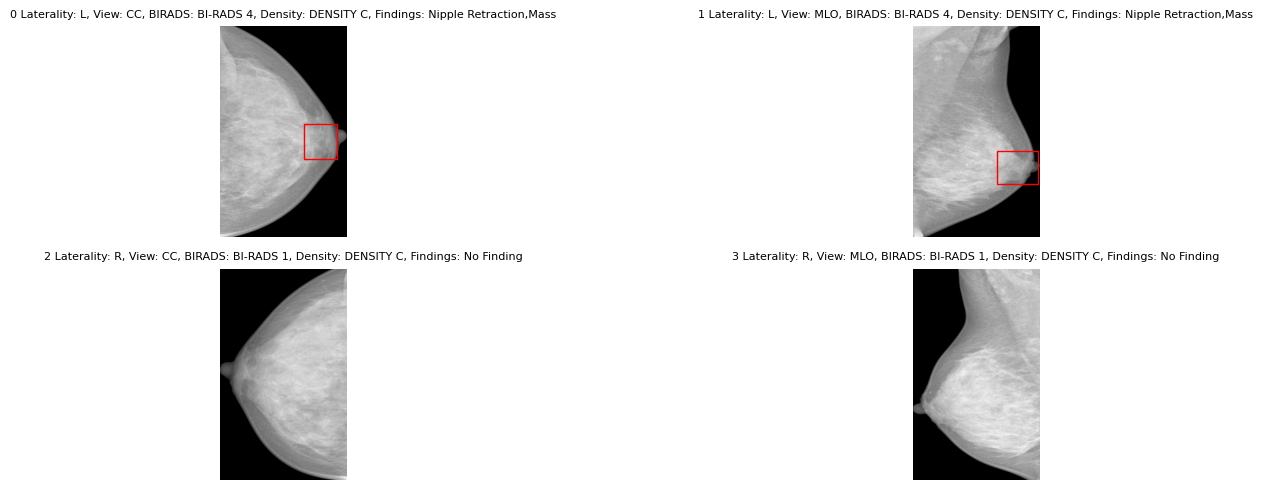

In [7]:
#Let's view a sample of this 

display_images(data, 8)

#How do we differentiate which bounding box represents Mass or Nipple Retraction? The 2nd Frame looks more like Nipple Retraction

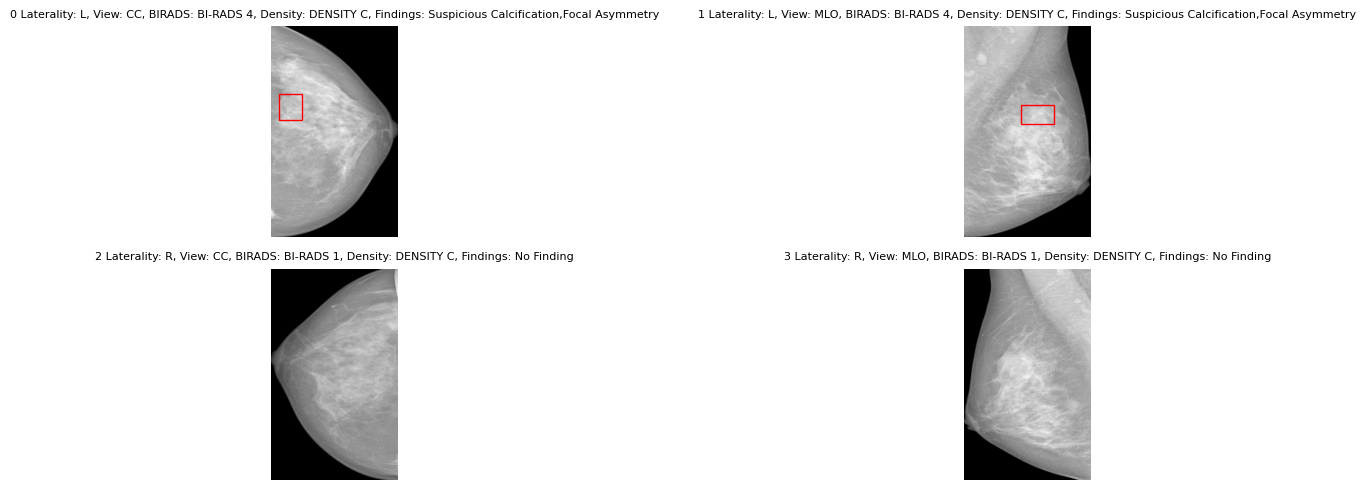

In [8]:
display_images(data, 21)

#How do we differentiate in this case between what Bounding Box belongs to Suspicious Calcification or Focal Asymmetry? The Bounding Box can represent both Categories

Cannot Display /kaggle/input/vindr-mammogram-dataset-dicom-to-png/images_png/b57b97020df361371ae1877080433275/7a6c57ce6034053ca02a8cd32549db7f.png, because of error:index 4 is out of bounds for axis 0 with size 4


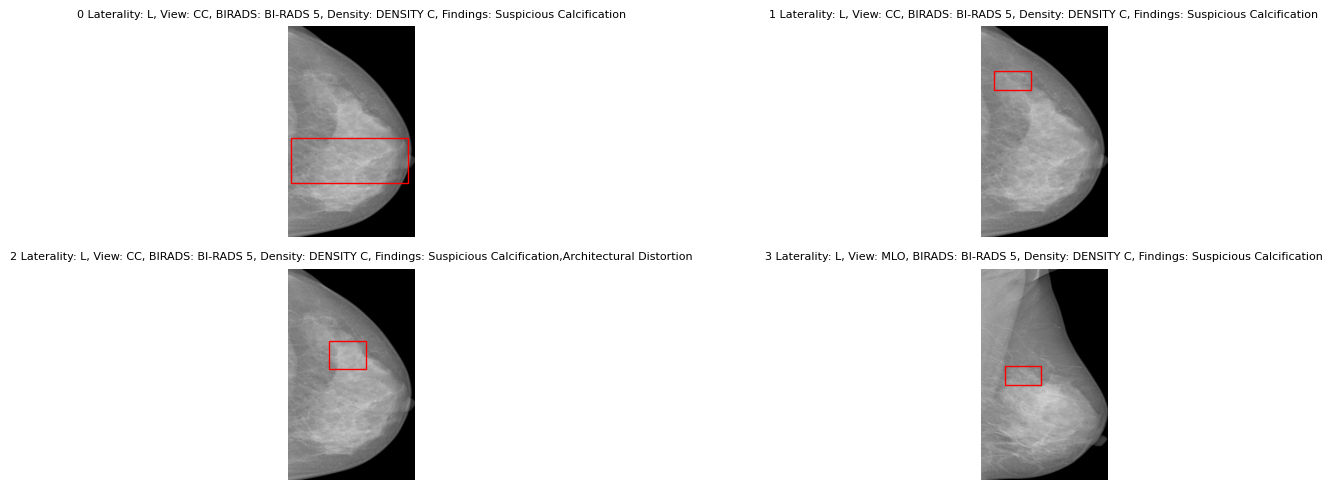

In [9]:
display_images(data, 37)

In [10]:
from collections import defaultdict

category = defaultdict(int)

for i, row in dw.iterrows():
    cats = row['finding_categories']
    for cat in cats:
        category[cat] += 1

category

defaultdict(int,
            {'Mass': 1226,
             'Global Asymmetry': 26,
             'Architectural Distortion': 119,
             'Nipple Retraction': 37,
             'Suspicious Calcification': 543,
             'Focal Asymmetry': 269,
             'Asymmetry': 97,
             'Skin Thickening': 57,
             'Suspicious Lymph Node': 57,
             'Skin Retraction': 18})

In [11]:
#To solve our problem of overlapping abnormalities for one bounding box, we decide to use a weighting function, based on the number of
# samples belonging to each unique abnormality, anywhere we find overlapping abnormalities, we take the abnormality which has a higher weight in terms of frequency

def chosen_category(cats:List) -> str:
    weights = []
    for cat in cats:
        weights.append(category[cat])

    idx = np.argmax(weights)
    return cats[idx]


dw['category'] = dw['finding_categories'].apply(chosen_category)
    

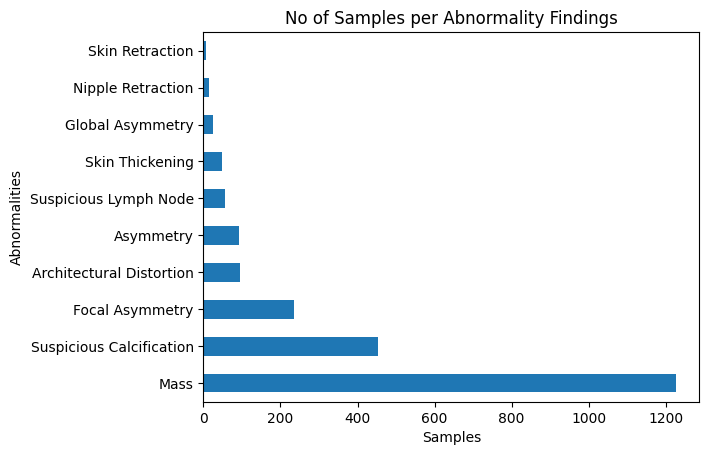

In [12]:
dw['category'].value_counts().plot(kind='barh', title="No of Samples per Abnormality Findings", ylabel="Abnormalities", xlabel="Samples");

In [21]:
cat_map = {k:list(category.keys()).index(k) for k in category.keys()}
cat_map

{'Mass': 0,
 'Global Asymmetry': 1,
 'Architectural Distortion': 2,
 'Nipple Retraction': 3,
 'Suspicious Calcification': 4,
 'Focal Asymmetry': 5,
 'Asymmetry': 6,
 'Skin Thickening': 7,
 'Suspicious Lymph Node': 8,
 'Skin Retraction': 9}

In [22]:
dw['category'] = dw['category'].map(cat_map)

In [23]:
c2dw = dw[(dw['category']==0) | (dw['category']==4)].reset_index().copy()

In [24]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

train, test = train_test_split(c2dw, test_size=0.3, stratify=c2dw['category'])

val, test = train_test_split(test, test_size=0.1, stratify=test['category'])

In [25]:
train, val, test = train.reset_index(), val.reset_index(), test.reset_index()

In [26]:
os.makedirs('train/images', exist_ok=True)
os.makedirs('train/labels', exist_ok=True)

os.makedirs('val/images', exist_ok=True)
os.makedirs('val/labels', exist_ok=True)

os.makedirs('test/images', exist_ok=True)
os.makedirs('test/labels', exist_ok=True)

In [27]:
source_path = "/kaggle/input/vindr-mammogram-dataset-dicom-to-png/images_png/"

In [28]:
def get_bboxes_yolo(data, src_path, dst_path, label_path):
    for i, row in tqdm(enumerate(data.itertuples()), desc="Getting BBoxes.."):
        # Build image path
        src_img_path = os.path.join(src_path, row.patient_id, f"{row.image_id}")
        dst_img_path = os.path.join(dst_path, f"{row.image_id}")
        label_file_path = os.path.join(label_path, f"{row.image_id.split('.')[0]}.txt")

        # Open and show image
        if os.path.exists(src_img_path):
            img = Image.open(src_img_path)
            shutil.copy(src_img_path, dst_img_path)
            width, height = img.size
        
            # Calculate YOLO format coordinates
            x_center = ((row.resized_xmin + row.resized_xmax) / 2) / width
            y_center = ((row.resized_ymin + row.resized_ymax) / 2) / height
            width = (row.resized_xmax - row.resized_xmin) / width
            height = (row.resized_ymax - row.resized_ymin) / height

            text = [row.category, x_center, y_center, width, height]
            with open(label_file_path, 'w') as f:
                text = [str(i) for i in text]
                f.write(' '.join(text))
        else:
            print(f"FILE NOT FOUND {src_img_path}")


        
get_bboxes_yolo(train, src_path=source_path, dst_path="/kaggle/working/train/images", label_path="/kaggle/working/train/labels")
get_bboxes_yolo(val, src_path=source_path, dst_path="/kaggle/working/val/images", label_path="/kaggle/working/val/labels")
get_bboxes_yolo(test, src_path=source_path, dst_path="/kaggle/working/test/images", label_path="/kaggle/working/test/labels")

Getting BBoxes..: 0it [00:00, ?it/s]

Getting BBoxes..: 0it [00:00, ?it/s]

Getting BBoxes..: 0it [00:00, ?it/s]

In [29]:
data = dict(
    train = "/kaggle/working/train/images",
    val = "/kaggle/working/val/images",
    test =  "/kaggle/working/test/images",

    nc = len(cat_map),
    names = list(cat_map.keys())
)

with open('/kaggle/working/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile)

In [30]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.0/871.0 kB 14.8 MB/s eta 0:00:00a 0:00:01


In [31]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 379MB/s]


In [ ]:
yaml_file = '/kaggle/working/data.yaml'

model.train(data=yaml_file,
            epochs=50,
            patience=20,
            batch=-1,
            name = f'yolov8s_2classes',
            save=True,
            amp=True,
            val=True)

In [ ]:
# Define the path to the directory
post_training_files_path = '/kaggle/working/runs/detect/yolov8s_2classes/'

# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

In [35]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

In [ ]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#9b63b8'}, style='darkgrid')

def display_images(post_training_files_path, image_files):
    
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = '/kaggle/working/runs/detect/yolov8s_2classes/'

# Display the images
display_images(post_training_files_path, image_files)